### Importation des données

In [1]:
import pandas as pd
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.regression.linear_model as sm
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier

### Analyse des données

In [4]:
def concat_data_with_different_sampling(data,min_sample_len):
    ratio = int(len(data)/min_sample_len)
    new_sampled_df = pd.DataFrame(index=range(min_sample_len))
    
    resampled_list = []
    
    for window in range(min_sample_len):
        resampled_list.extend([window]*ratio)
    
    data['sampled'] = resampled_list
    
    new_sampled_df = data.groupby('sampled').agg(["mean"],axis="columns")
    
    new_sampled_df.columns= data.columns.drop('sampled')
            
    return new_sampled_df


concat_data = pd.DataFrame()

for subject in range(1,16):
    # open file
    num_patient = f"S{subject}"
    path = f"./PPG_FieldStudy/{num_patient}/{num_patient}.pkl"
    with open(path, "rb") as f:
        data = pickle.load(f, encoding="latin-1")
    
    # extract chest data
    chest_data = pd.DataFrame(index=range(len(data["signal"]['chest']["ACC"])))
    dico = data["signal"]['chest']
    for key in dico:
        if key != "ACC":
            chest_data[f'chest_{key}'] = pd.DataFrame(dico[key])
        else:
            chest_data = pd.concat([chest_data, pd.DataFrame(data["signal"]['chest']['ACC'], 
                                                 columns=['chest_ACC_X', 'chest_ACC_Y', 'chest_ACC_Z'])],axis=1)
    # add repeaks to the chest data
    list_rpeaks = [0]*len(chest_data)
    for index in data['rpeaks']:
        list_rpeaks[index] = 1
    chest_data['rpeaks'] = list_rpeaks
    
    # resampling chest data to the min value we have : 'EDA'
    resampled_size = len(data["signal"]['wrist']['EDA'])
    concat_chest_data = concat_data_with_different_sampling(chest_data,min_sample_len=resampled_size)
    concat_chest_data
    
    # extract wrist ACC data
    wrist_ACC_data = pd.DataFrame(data["signal"]['wrist']['ACC'],columns=['wrist_ACC_X', 'wrist_ACC_Y', 'wrist_ACC_Z'])
    # resampling wrist ACC data to the min value we have : 'EDA'
    concat_wrist_ACC_data = concat_data_with_different_sampling(wrist_ACC_data,resampled_size)
    
    # extract wrist BVP data
    wrist_BVP_data = pd.DataFrame(data["signal"]['wrist']['BVP'],columns=['BVP'])
    # resampling wrist BVP data to the min value we have : 'EDA'
    concat_wrist_BVP_data = concat_data_with_different_sampling(wrist_BVP_data,resampled_size)
    
    # concat all wrist data and let down the temp value which is factice
    concat_wrist_data = pd.concat([concat_wrist_BVP_data, concat_wrist_ACC_data,pd.DataFrame(data["signal"]['wrist']['EDA'],columns=['EDA'])],axis=1)
    
    # we concat the concat wrist data, the concat chest data and the activity label
    concat_subject_data=pd.concat([concat_wrist_data,concat_chest_data,pd.DataFrame(data['activity'],columns=['activity'])],axis=1)
    
    # we add questionnay info to the dataset
    for key in data['questionnaire']:
        concat_subject_data[key]=data['questionnaire'][key]
        
    concat_subject_data['subject']=data['subject']

    concat_data = pd.concat([concat_data,concat_subject_data],axis=0)
    
concat_data.head()

,BVP,wrist_ACC_X,wrist_ACC_Y,wrist_ACC_Z,EDA,chest_ACC_X,chest_ACC_Y,chest_ACC_Z,chest_ECG,chest_EMG,...,chest_Resp,rpeaks,activity,WEIGHT,Gender,AGE,HEIGHT,SKIN,SPORT,subject
0,0.138125,-0.763672,-0.076172,0.669922,4.722437,0.852157,-0.066488,-0.367784,0.035650,-1.5,...,4.834438,0.000000,0.0,78.0,m,34,182.0,3,6,S1
1,-26.262500,-0.763672,-0.078125,0.671875,4.728843,0.851262,-0.066655,-0.370442,0.103145,-1.5,...,4.238839,0.005714,0.0,78.0,m,34,182.0,3,6,S1
2,-40.959375,-0.761719,-0.078125,0.671875,4.718594,0.851570,-0.064677,-0.370251,0.099101,-1.5,...,2.058559,0.000000,0.0,78.0,m,34,182.0,3,6,S1
3,24.173125,-0.753906,-0.078125,0.671875,4.717312,0.852142,-0.065486,-0.371278,-0.170757,-1.5,...,-0.463981,0.000000,0.0,78.0,m,34,182.0,3,6,S1
4,25.781250,-0.761719,-0.076172,0.671875,4.713469,0.851958,-0.065894,-0.370466,-0.036633,-1.5,...,-1.867397,0.000000,0.0,78.0,m,34,182.0,3,6,S1


### Matrice de corrélation

In [16]:
corr = concat_data.corr()
corr.style.background_gradient(cmap='coolwarm')

C:\Users\a2c18\Anaconda3\lib\site-packages\matplotlib\colors.py:527: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


,BVP,wrist_ACC_X,wrist_ACC_Y,wrist_ACC_Z,EDA,chest_ACC_X,chest_ACC_Y,chest_ACC_Z,chest_ECG,chest_EMG,chest_EDA,chest_Temp,chest_Resp,rpeaks,activity,WEIGHT,AGE,HEIGHT,SKIN,SPORT
BVP,1,0.0121889,-0.00353677,0.00298939,-2.01337e-05,0.00144175,0.00196359,0.000349,0.0084808,nan,nan,nan,-0.000156235,0.00148989,-3.00541e-05,-9.72253e-06,8.01595e-06,-5.57649e-06,-4.68001e-06,-1.69618e-05
wrist_ACC_X,0.0121889,1,0.0538383,0.281751,0.0536325,-0.0342697,0.0235854,0.00628401,-0.000207301,nan,nan,nan,0.00273454,0.0240044,0.0379147,0.136799,-0.0454036,0.125855,-0.0898183,0.0454531
wrist_ACC_Y,-0.00353677,0.0538383,1,-0.104929,0.0283177,0.0891536,0.035414,0.2402,0.000638916,nan,nan,nan,0.00236153,0.0489815,-0.290707,0.0784346,-0.0015254,0.0526524,-0.0360097,0.00206806
wrist_ACC_Z,0.00298939,0.281751,-0.104929,1,0.0336617,-0.173609,0.0455761,-0.157817,-0.000295047,nan,nan,nan,0.00111548,-0.0301343,0.198107,0.152955,0.00206639,0.165692,-0.0810018,0.135005
EDA,-2.01337e-05,0.0536325,0.0283177,0.0336617,1,-0.0402625,0.191499,-0.0979548,-0.00182903,nan,nan,nan,-0.00277506,0.0472843,-0.133152,0.212672,-0.11652,0.251188,-0.299623,-0.225413
chest_ACC_X,0.00144175,-0.0342697,0.0891536,-0.173609,-0.0402625,1,-0.117001,0.379374,0.0287322,nan,nan,nan,-0.00896337,0.0274295,-0.0827772,-0.22044,-0.102163,-0.1775,0.0790556,0.0717799
chest_ACC_Y,0.00196359,0.0235854,0.035414,0.0455761,0.191499,-0.117001,1,-0.0576548,0.0239583,nan,nan,nan,0.000724806,0.000182745,-0.0506682,0.168987,0.00729417,0.109185,-0.127117,0.0161157
chest_ACC_Z,0.000349,0.00628401,0.2402,-0.157817,-0.0979548,0.379374,-0.0576548,1,0.00493554,nan,nan,nan,-0.00921098,0.0618865,-0.14475,-0.255368,-0.176308,-0.174982,-0.00116669,0.133316
chest_ECG,0.0084808,-0.000207301,0.000638916,-0.000295047,-0.00182903,0.0287322,0.0239583,0.00493554,1,nan,nan,nan,0.0214288,0.154892,0.00117177,-3.08919e-05,6.27596e-05,-0.000470942,-0.000864933,-0.00266012
chest_EMG,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan


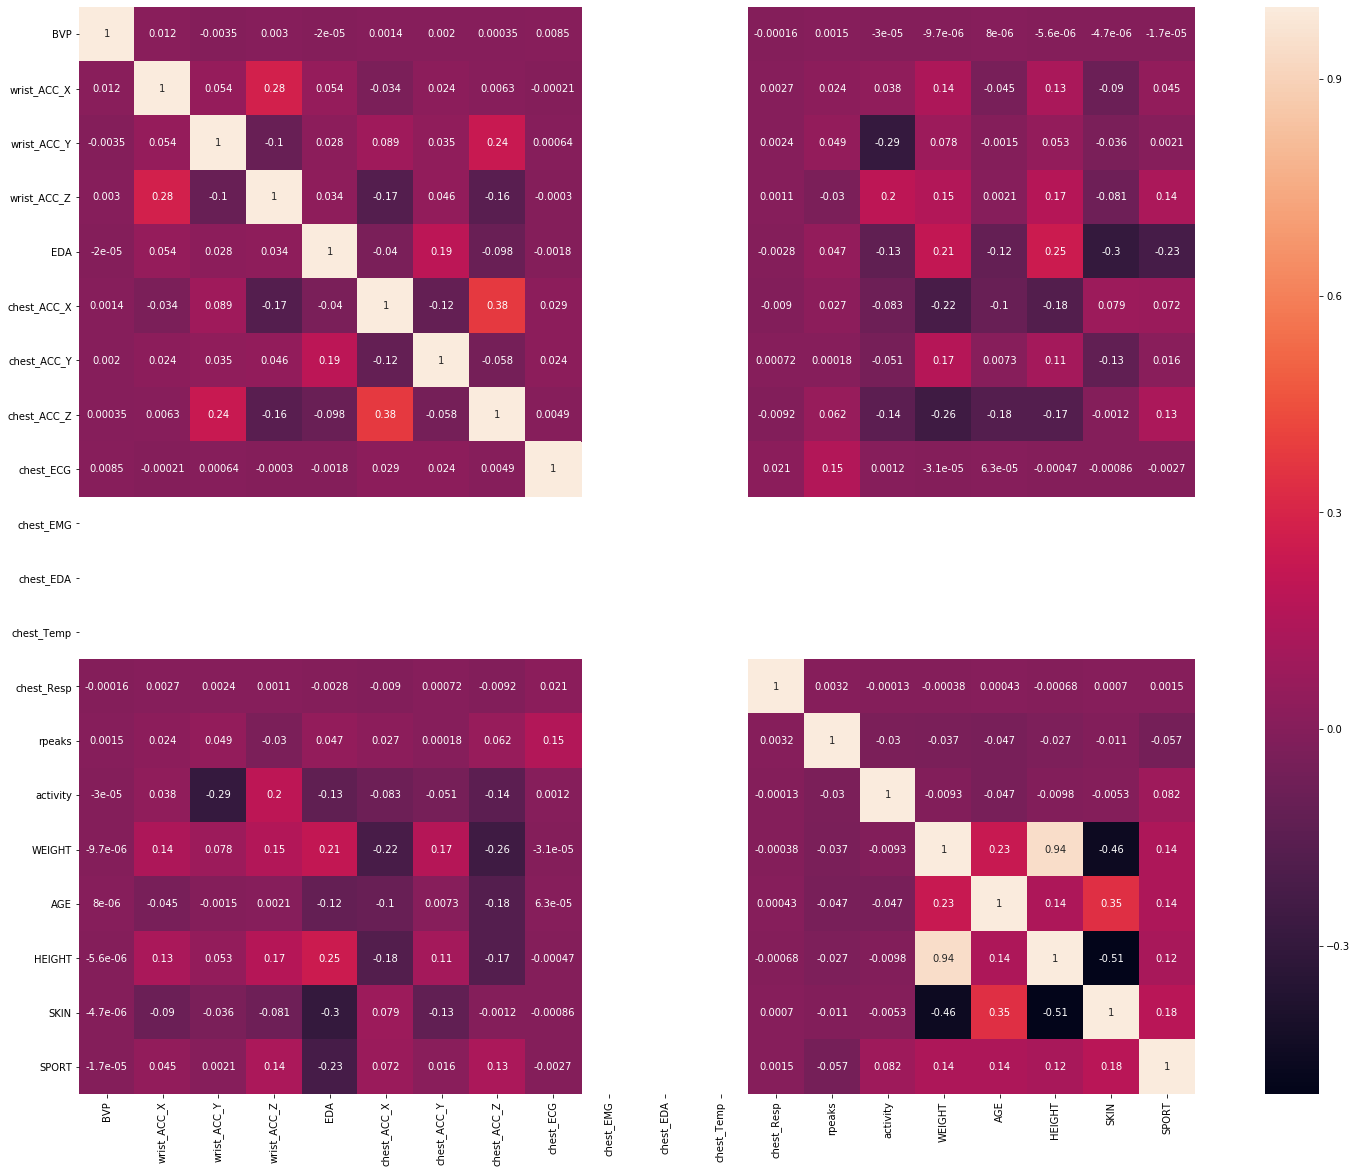

In [27]:
f, ax = plt.subplots(figsize=(25, 20))
sns.heatmap(corr, annot=True)

### Charts

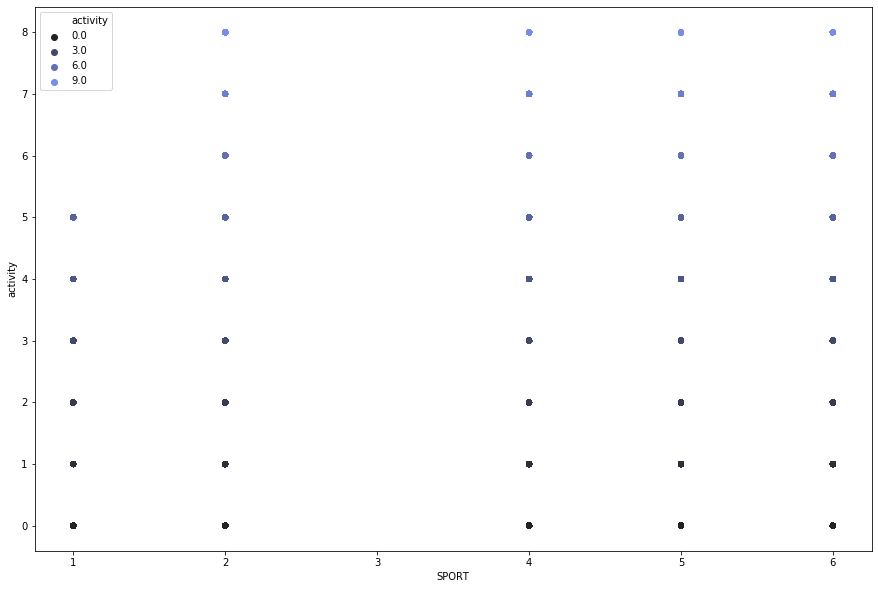

In [90]:
f, ax = plt.subplots(figsize=(15, 10))
sns.scatterplot(x="SPORT", y="activity",linewidth=0,
                data=concat_data,hue="activity",palette=sns.dark_palette((260, 75, 60), input="husl", as_cmap=True))

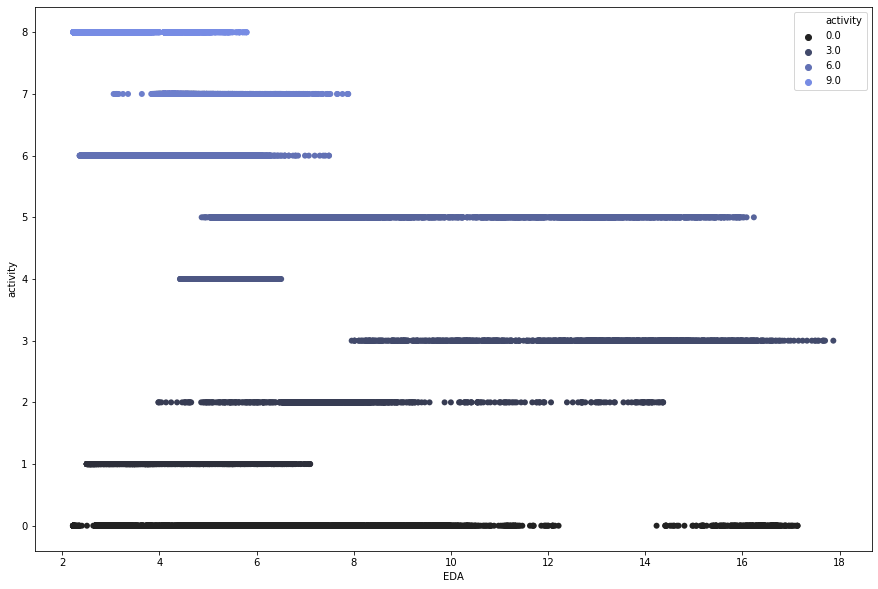

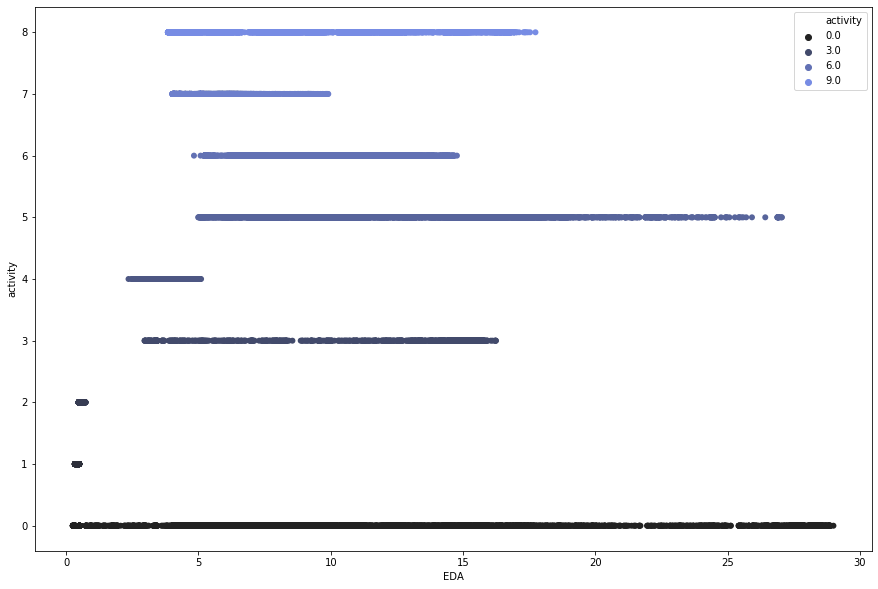

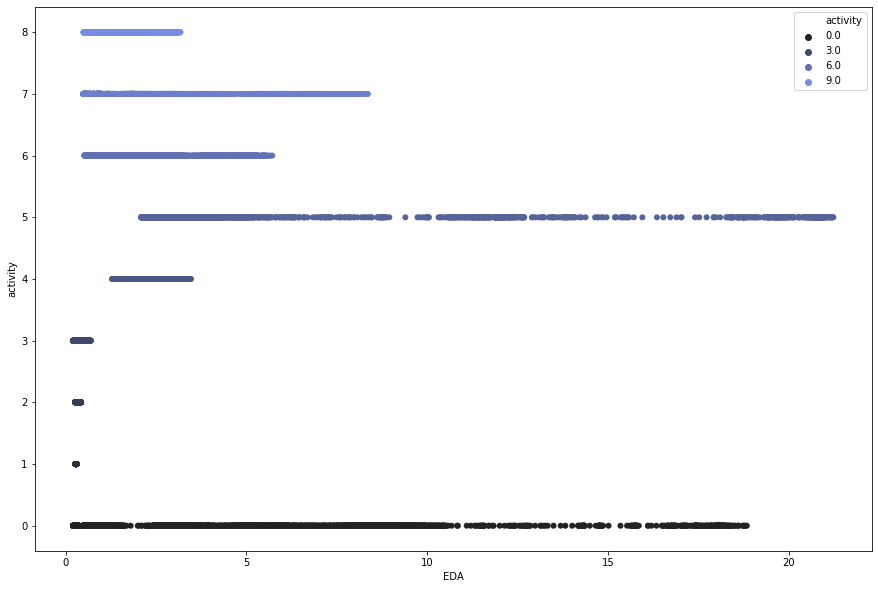

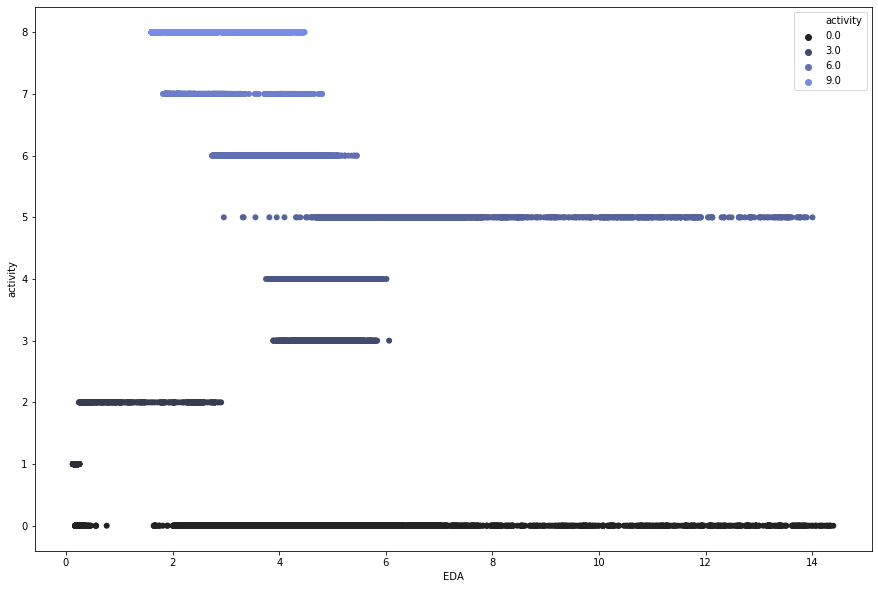

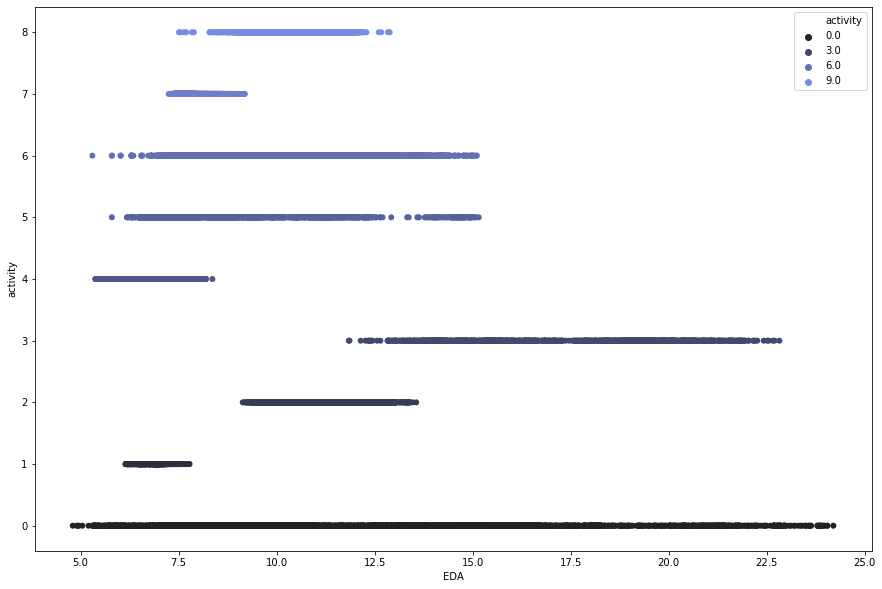

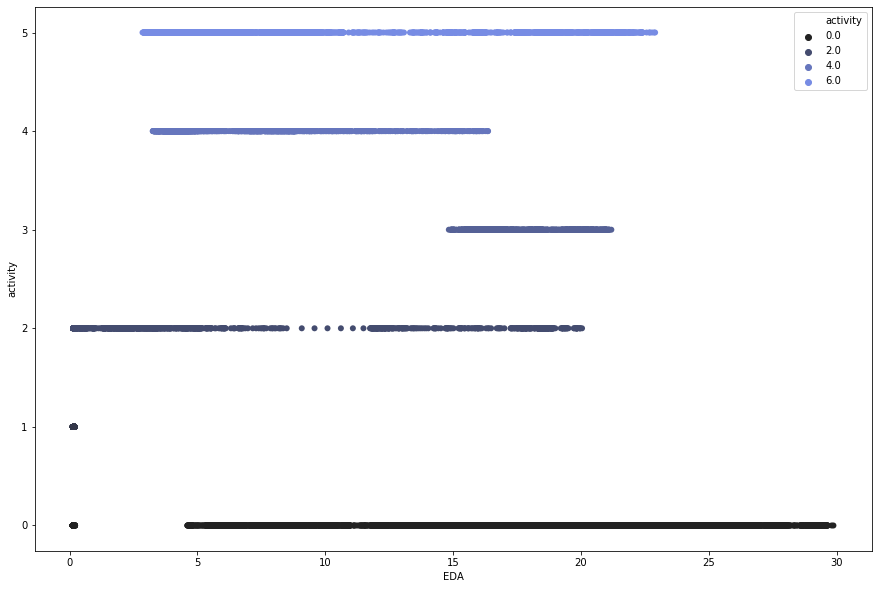

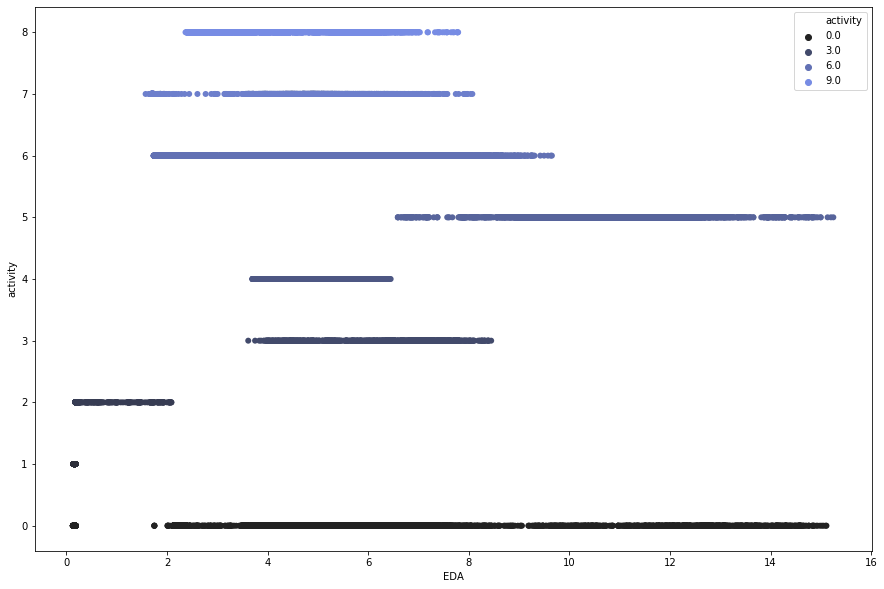

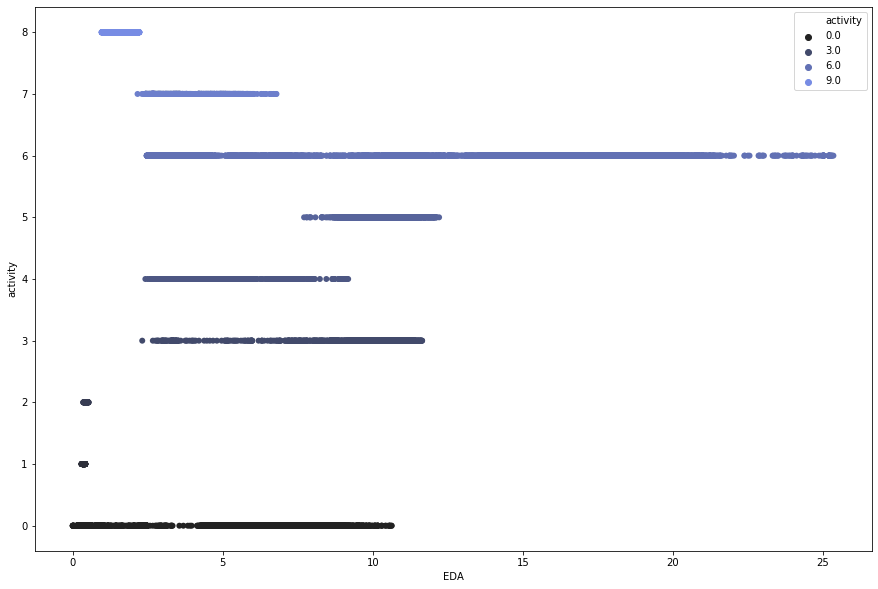

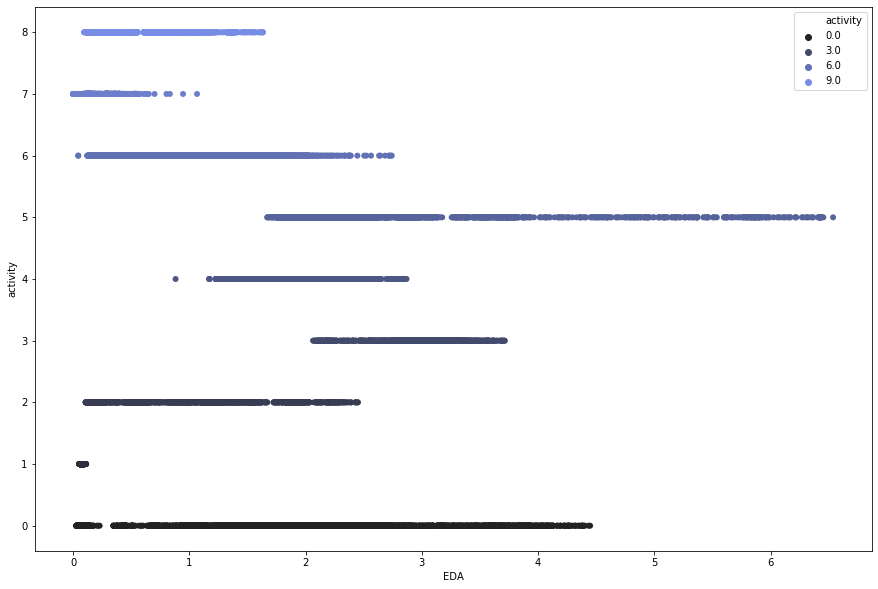

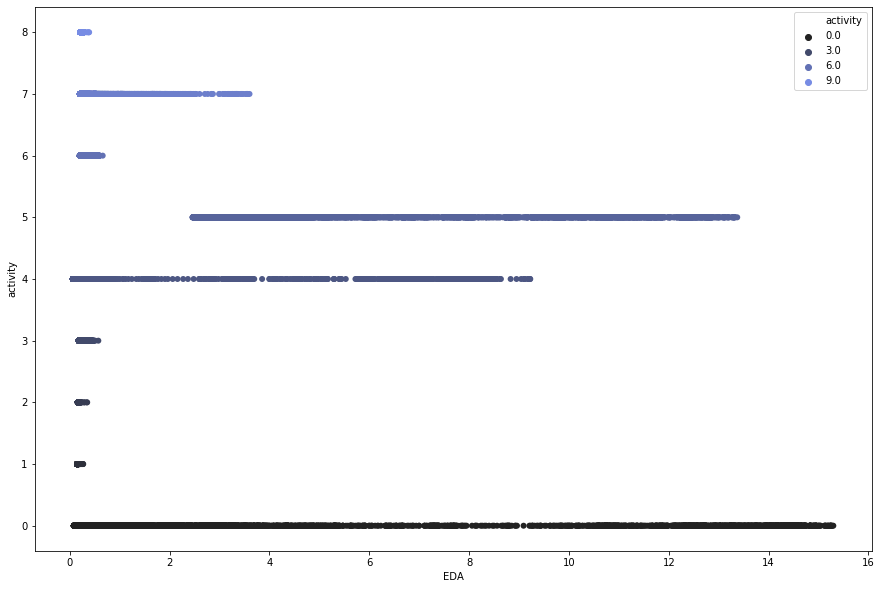

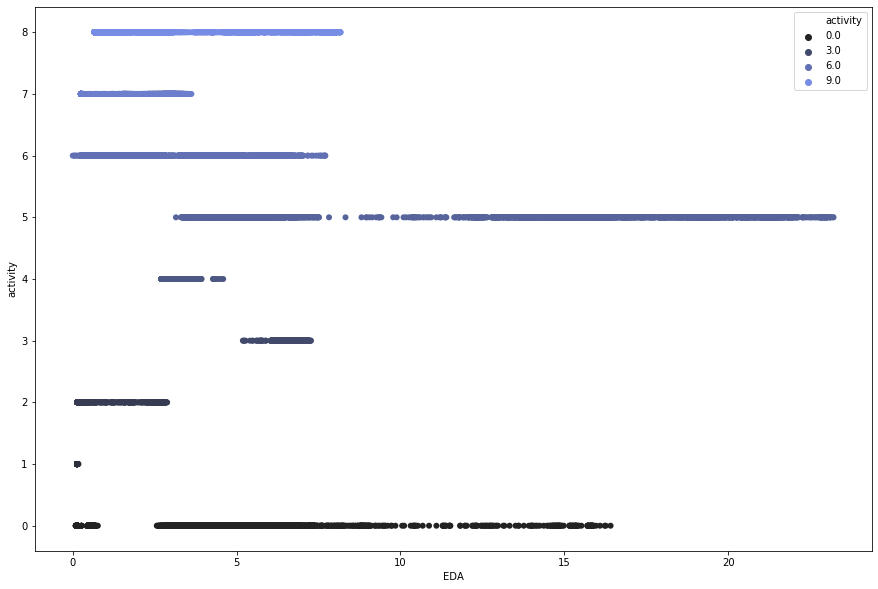

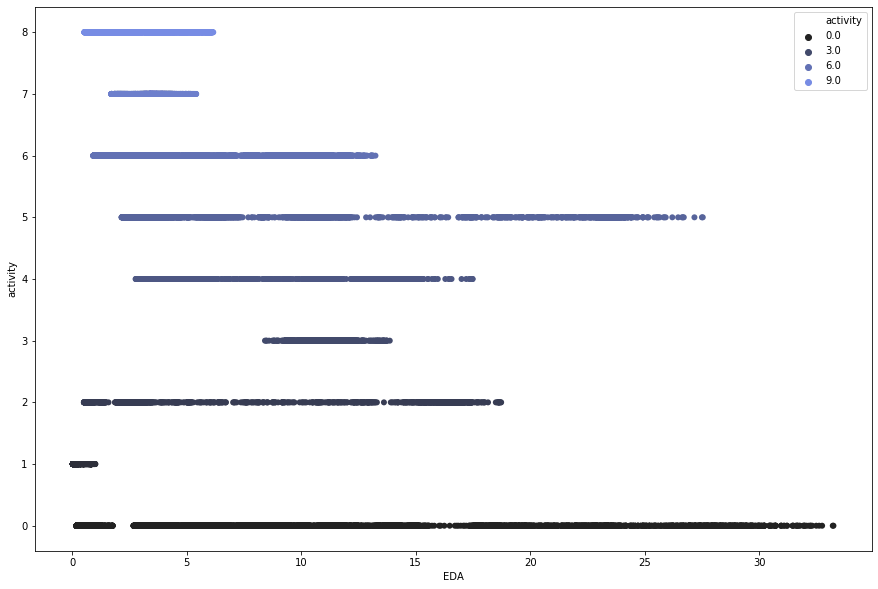

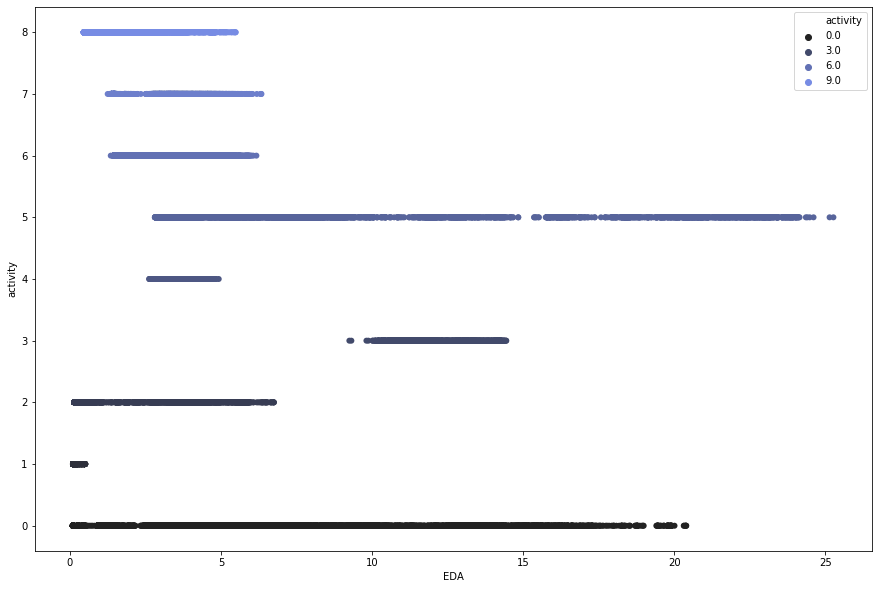

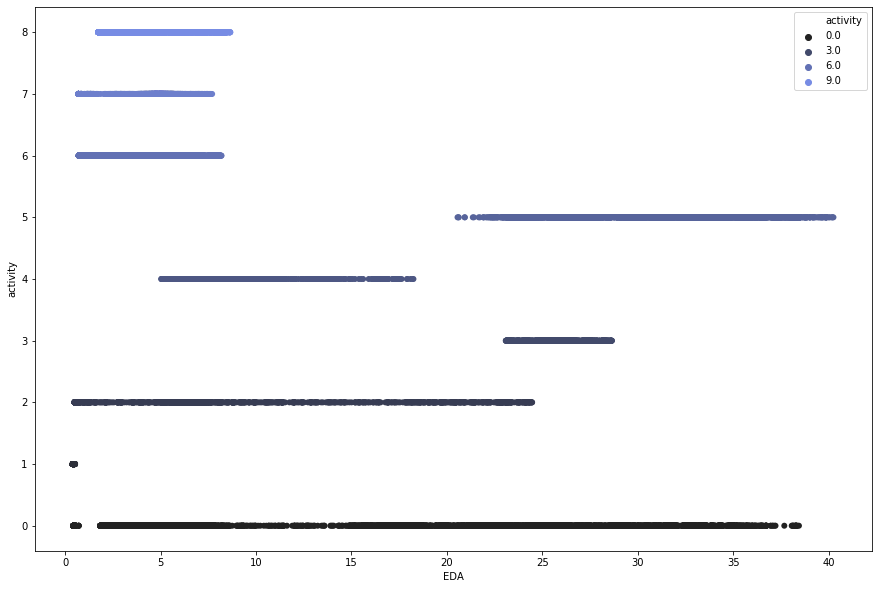

In [94]:
for subject in range(1,15):
    data = concat_data[concat_data['subject'] == f'S{subject}' ]
    f, ax = plt.subplots(figsize=(15, 10))
    sns.scatterplot(x="EDA", y="activity",linewidth=0,
                    data=data,hue="activity",palette=sns.dark_palette((260, 75, 60), input="husl", as_cmap=True))

### Blood Volume Pulse

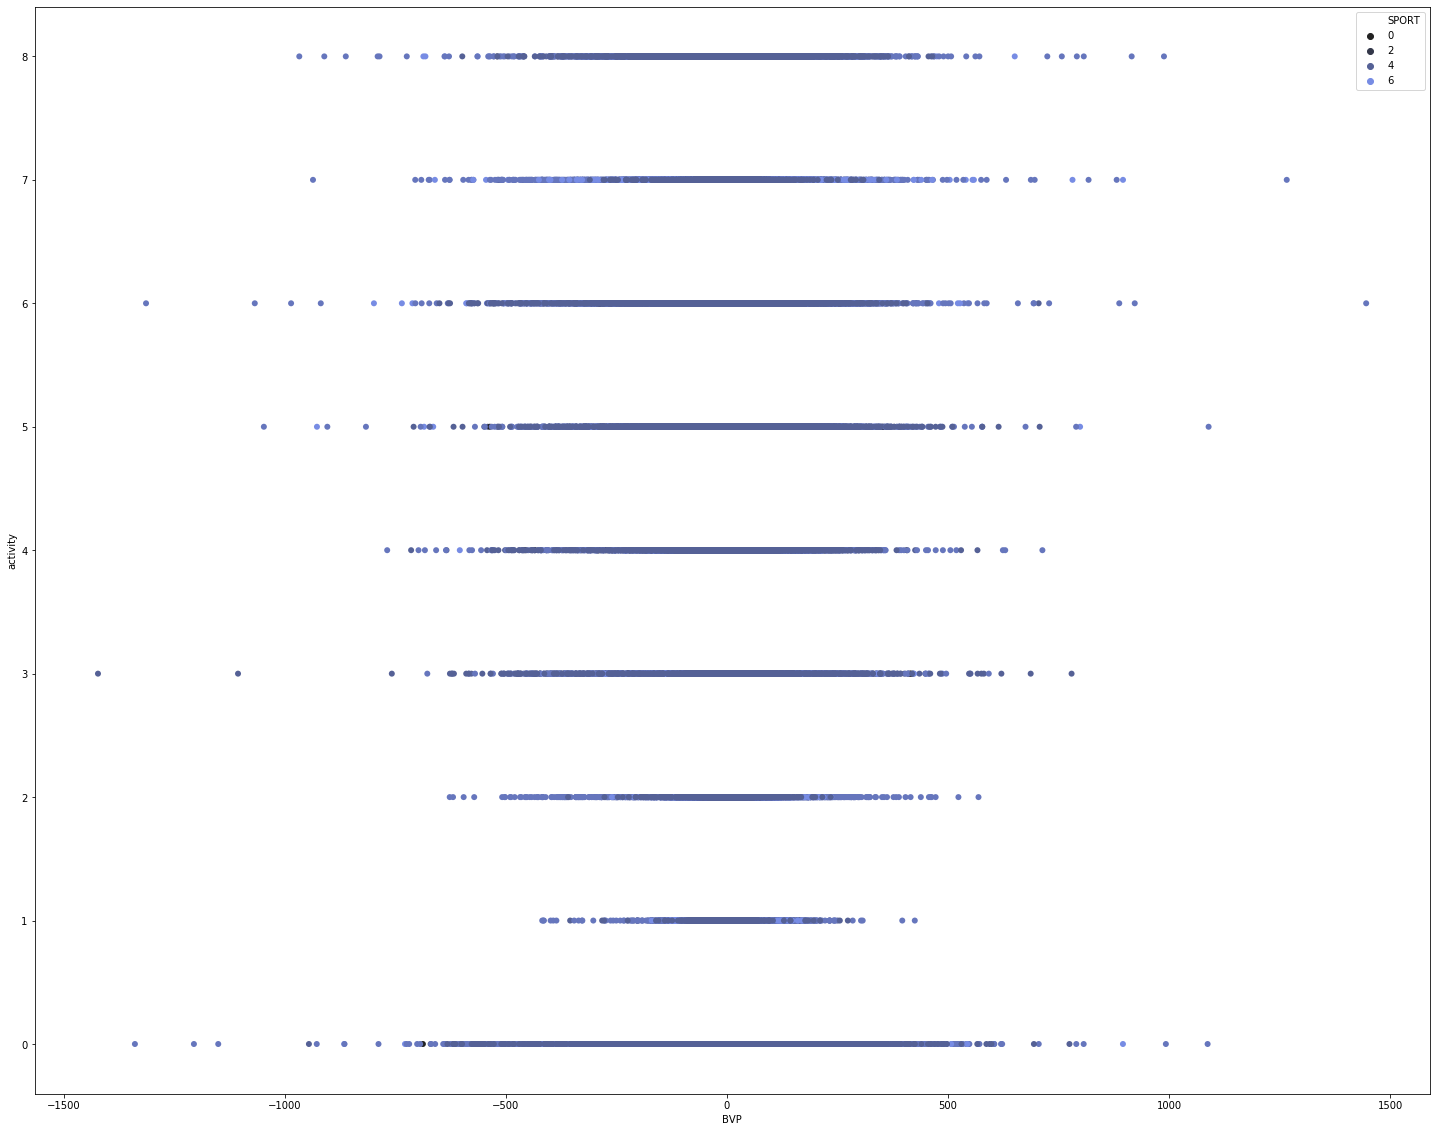

In [86]:
f, ax = plt.subplots(figsize=(25, 20))
sns.scatterplot(x="BVP", y="activity", linewidth=0,
                data=concat_data,hue ='SPORT',palette=sns.dark_palette((260, 75, 60), input="husl", as_cmap=True))

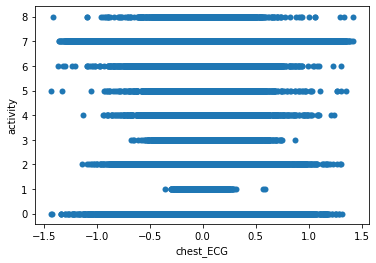

In [76]:
sns.scatterplot(x="chest_ECG", y="activity",
                sizes=(1, 8), linewidth=0,
                data=concat_data)

<IPython.core.display.Javascript object>


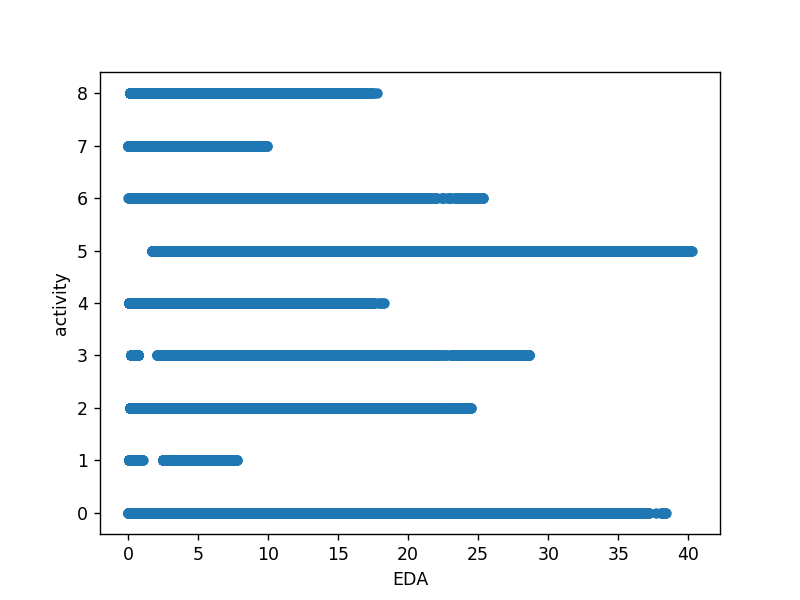

In [70]:
sns.scatterplot(x="EDA", y="activity",
                palette="ch:r=-.2,d=.3_r",
                sizes=(1, 8), linewidth=0,
                data=concat_data)

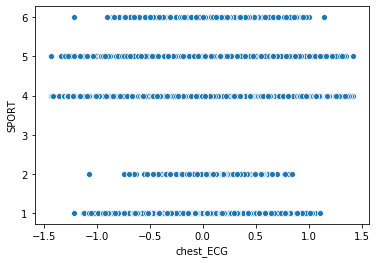

In [3]:
sns.scatterplot(x="chest_ECG", y="SPORT",data=concat_data)

### One hot encode

In [5]:
concat_data = pd.concat([concat_data, pd.get_dummies(concat_data['Gender'])],axis=1)
concat_data.drop(columns=['Gender'], inplace=True)

# concat_data = pd.concat([concat_data, pd.get_dummies(concat_data['subject'])],axis=1)
concat_data.drop(columns=['subject'], inplace=True)

### Feature selection based on p-value

In [6]:
concat_data_reduce = concat_data.drop(columns=['activity'])
selected_columns = concat_data_reduce.columns


print(f'columns before filtering with p value : {selected_columns}')

def backwardElimination(x, Y, sl, columns):
    numVars = len(x[0])
    for i in range(0, numVars):
        regressor_OLS = sm.OLS(Y, x).fit()
        maxVar = max(regressor_OLS.pvalues).astype(float)
        if maxVar > sl:
            for j in range(0, numVars - i):
                if (regressor_OLS.pvalues[j].astype(float) == maxVar):
                    x = np.delete(x, j, 1)
                    columns = np.delete(columns, j)
                    
    print(regressor_OLS.summary())
    return x, columns

SL = 0.05
data_modeled, selected_columns = backwardElimination(concat_data_reduce.values, concat_data['activity'].values, SL, selected_columns)

print(f'columns after filtering with p value : {selected_columns}')

columns before filtering with p value : Index(['BVP', 'wrist_ACC_X', 'wrist_ACC_Y', 'wrist_ACC_Z', 'EDA',
       'chest_ACC_X', 'chest_ACC_Y', 'chest_ACC_Z', 'chest_ECG', 'chest_EMG',
       'chest_EDA', 'chest_Temp', 'chest_Resp', 'rpeaks', 'WEIGHT', 'AGE',
       'HEIGHT', 'SKIN', 'SPORT', ' f', ' m'],
      dtype='object')
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.147
Model:                            OLS   Adj. R-squared:                  0.147
Method:                 Least Squares   F-statistic:                     6840.
Date:                Fri, 31 Jan 2020   Prob (F-statistic):               0.00
Time:                        13:37:33   Log-Likelihood:            -1.2594e+06
No. Observations:              517956   AIC:                         2.519e+06
Df Residuals:                  517942   BIC:                         2.519e+06
Df Model:                          13   

C:\Users\a2c18\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
C:\Users\a2c18\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


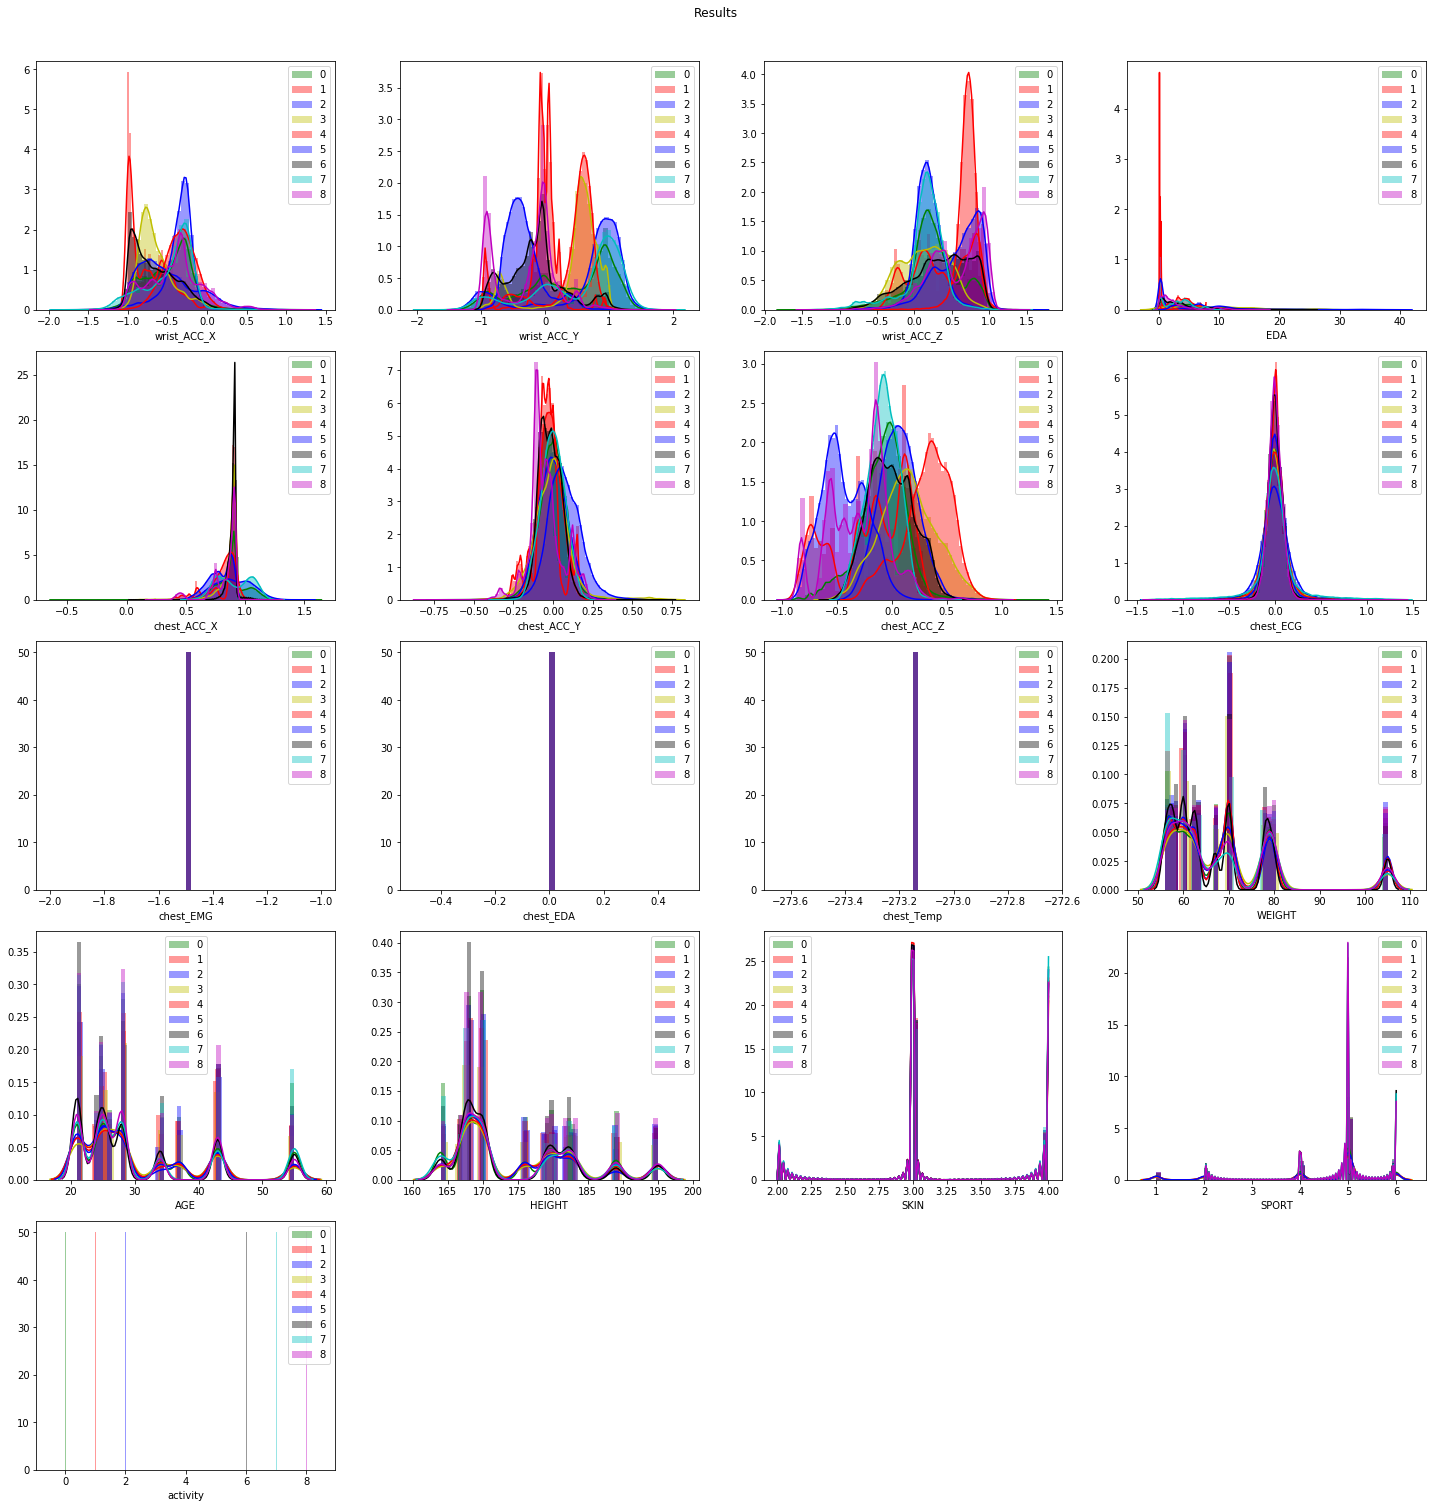

In [25]:
data = pd.DataFrame(data = data_modeled, columns = selected_columns)
data['activity'] = concat_data['activity'].values

fig = plt.figure(figsize = (20, 25))
j = 0
for i in data.columns:
    plt.subplot(6, 4, j+1)
    j += 1
    sns.distplot(data[i][data['activity']==0], color='g', label = '0')
    sns.distplot(data[i][data['activity']==1], color='r', label = '1')
    sns.distplot(data[i][data['activity']==2], color='b', label = '2')
    sns.distplot(data[i][data['activity']==3], color='y', label = '3')
    sns.distplot(data[i][data['activity']==4], color='r', label = '4')
    sns.distplot(data[i][data['activity']==5], color='b', label = '5')
    sns.distplot(data[i][data['activity']==6], color='k', label = '6')
    sns.distplot(data[i][data['activity']==7], color='c', label = '7')
    sns.distplot(data[i][data['activity']==8], color='m', label = '8')
    plt.legend(loc='best')
fig.suptitle('Results')
fig.tight_layout()
fig.subplots_adjust(top=0.95)
plt.show()

### Split train and test

In [7]:
reduced_df = concat_data[selected_columns]
reduced_df['activity'] = concat_data['activity']

train, test = train_test_split(reduced_df, test_size=0.2)

x_train = train.drop(columns=['activity'])
y_train = train['activity']

x_test = test.drop(columns=['activity'])
y_test = test['activity']

C:\Users\a2c18\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


### Random Forest

In [10]:
RF_clf = RandomForestClassifier(n_estimators=50)
RF_clf.fit(x_train, y_train)

y_pred_RF = RF_clf.predict(x_test)

In [38]:
print(metrics.classification_report(y_test,y_pred_RF))

              precision    recall  f1-score   support

         0.0       0.89      0.94      0.91     28411
         1.0       0.99      0.99      0.99      7266
         2.0       0.92      0.84      0.88      5158
         3.0       0.94      0.90      0.92      3631
         4.0       0.97      0.98      0.98      5542
         5.0       0.97      0.99      0.98     10840
         6.0       0.97      0.95      0.96     21578
         7.0       0.88      0.82      0.85      7510
         8.0       0.99      0.97      0.98     13656

    accuracy                           0.94    103592
   macro avg       0.95      0.93      0.94    103592
weighted avg       0.94      0.94      0.94    103592



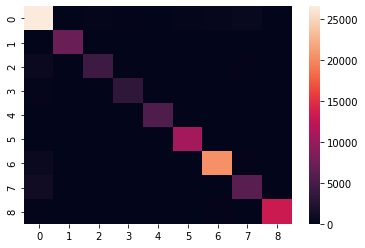

In [39]:
sns.heatmap(confusion_matrix(y_test,y_pred_RF))

### Gradient Boosting Classifier

In [9]:
GBC = GradientBoostingClassifier()
GBC.fit(x_train,y_train)

y_pred_gbc = GBC.predict(x_test)

In [10]:
print(metrics.classification_report(y_test,y_pred_gbc))

              precision    recall  f1-score   support

         0.0       0.69      0.73      0.71     28411
         1.0       0.91      0.97      0.94      7266
         2.0       0.78      0.58      0.66      5158
         3.0       0.78      0.69      0.74      3631
         4.0       0.90      0.94      0.92      5542
         5.0       0.89      0.93      0.91     10840
         6.0       0.80      0.86      0.83     21578
         7.0       0.68      0.46      0.55      7510
         8.0       0.88      0.85      0.87     13656

    accuracy                           0.80    103592
   macro avg       0.81      0.78      0.79    103592
weighted avg       0.79      0.80      0.79    103592



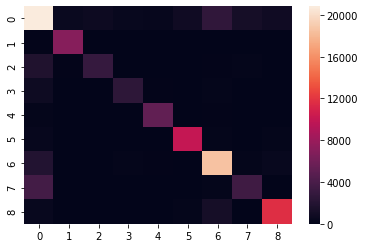

In [11]:
sns.heatmap(confusion_matrix(y_test,y_pred_gbc))

### KNN classifier

In [12]:
result_f1 = []

for n in range(1,10):
    print(f"n neigbors : {n}")
    KNC = KNeighborsClassifier(n_neighbors=n)
    KNC.fit(x_train,y_train)
    y_pred_KNC = KNC.predict(x_test)
    
    print(metrics.f1_score(y_test,y_pred_KNC,average='micro'))

    result_f1.append(metrics.f1_score(y_test,y_pred_KNC,average='micro'))

n neigbors : 1
0.9234979535099236
n neigbors : 2
0.9203799521198548
n neigbors : 3
0.925554096841455
n neigbors : 4
0.9235172600200787
n neigbors : 5
0.9223299096455325
n neigbors : 6
0.9209784539346668
n neigbors : 7
0.919279481041007
n neigbors : 8
0.9180149046258399
n neigbors : 9
0.9167117151903622


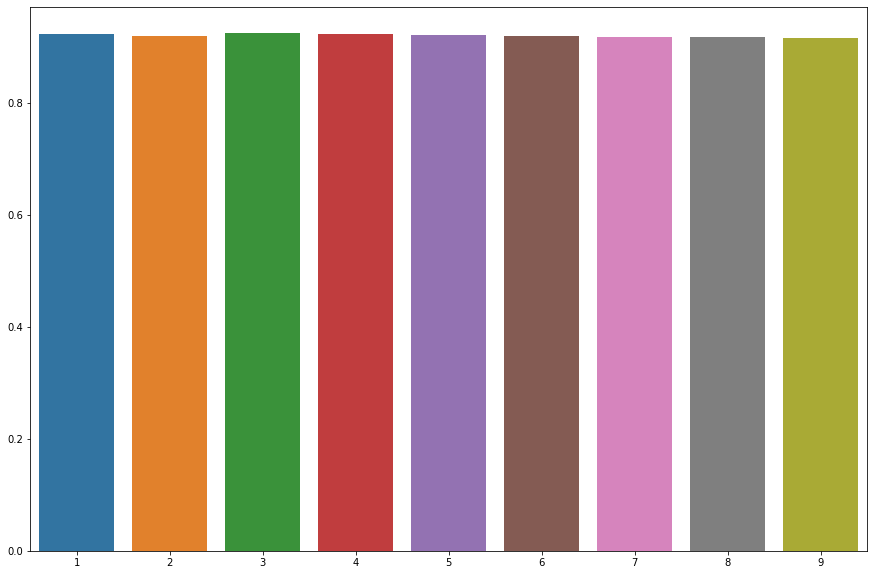

In [23]:
f, ax = plt.subplots(figsize=(15, 10))
sns.barplot(list(range(1,10)), result_f1)

In [13]:
KNC = KNeighborsClassifier(n_neighbors=3)
KNC.fit(x_train,y_train)
y_pred_KNC = KNC.predict(x_test)

print(metrics.classification_report(y_test,y_pred_KNC))

              precision    recall  f1-score   support

         0.0       0.89      0.89      0.89     28411
         1.0       0.97      0.99      0.98      7266
         2.0       0.86      0.78      0.82      5158
         3.0       0.91      0.93      0.92      3631
         4.0       0.97      0.98      0.97      5542
         5.0       0.97      0.98      0.98     10840
         6.0       0.94      0.96      0.95     21578
         7.0       0.83      0.80      0.81      7510
         8.0       0.97      0.97      0.97     13656

    accuracy                           0.93    103592
   macro avg       0.92      0.92      0.92    103592
weighted avg       0.93      0.93      0.93    103592



In [ ]:
sns.heatmap(confusion_matrix(y_test,y_pred_KNC))

### Comparaison des modèles

[0.9384953525723831, 0.7922425047986708, 0.9216727819060319]


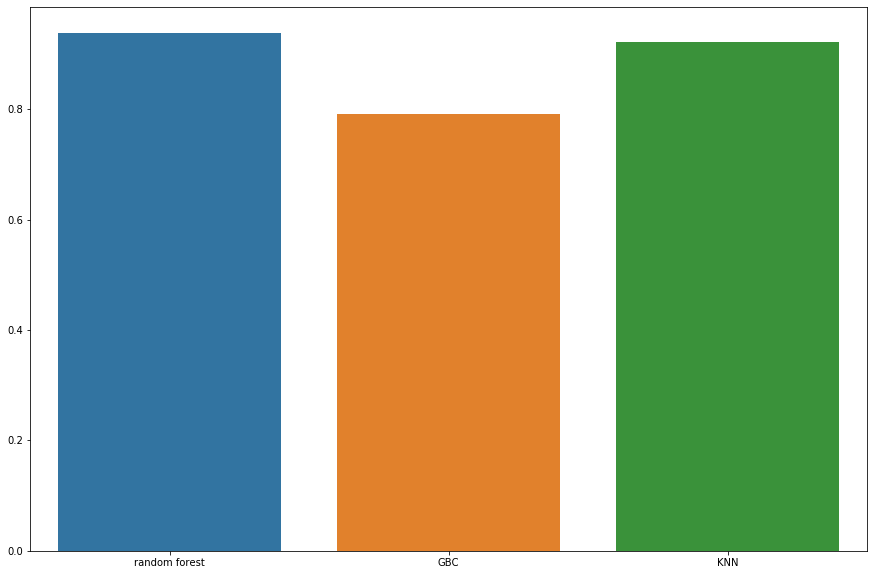

In [40]:
f, ax = plt.subplots(figsize=(15, 10))
list_score = [metrics.f1_score(y_test,y_pred_RF,average='macro'),metrics.f1_score(y_test,y_pred_gbc,average='macro'),metrics.f1_score(y_test,y_pred_KNC,average='macro')]
sns.barplot(['random forest', 'GBC', 'KNN'], list_score)
print(list_score)

### Randomized Search on Random Forest

In [7]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier

n_estimators = [int(x) for x in np.linspace(start = 20, stop = 200, num = 8)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 80, num = 5)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

print(random_grid)

RandomForest_GridSearch_Clf = RandomForestClassifier()

rf_random = RandomizedSearchCV(estimator = RandomForest_GridSearch_Clf, param_distributions = random_grid, n_iter = 30, cv = 3, verbose=2, random_state=42, n_jobs = -1)
rf_random.fit(x_train, y_train)

{'n_estimators': [20, 45, 71, 97, 122, 148, 174, 200], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 27, 45, 62, 80, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}
Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed: 37.2min
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed: 91.9min finished


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
                                                    n_estimators='warn',
                                                    n_jobs=None

In [12]:
rf_random.best_params_

{'n_estimators': 200,
 'min_samples_split': 5,
 'min_samples_leaf': 2,
 'max_features': 'sqrt',
 'max_depth': 45,
 'bootstrap': False}

### Tuned Random Forest

In [14]:
from sklearn.ensemble import RandomForestClassifier

tuned_random_forest_clf = RandomForestClassifier(n_estimators=200,min_samples_split=5, min_samples_leaf=2, max_features='sqrt',max_depth=45, bootstrap=False)
tuned_random_forest_clf.fit(x_train, y_train)

y_pred_tuned = tuned_random_forest_clf.predict(x_test)

In [15]:
print(metrics.classification_report(y_test,y_pred_tuned))

              precision    recall  f1-score   support

         0.0       0.90      0.94      0.92     28411
         1.0       0.99      0.99      0.99      7266
         2.0       0.92      0.85      0.89      5158
         3.0       0.95      0.91      0.93      3631
         4.0       0.98      0.98      0.98      5542
         5.0       0.97      0.99      0.98     10840
         6.0       0.97      0.95      0.96     21578
         7.0       0.88      0.83      0.86      7510
         8.0       0.99      0.97      0.98     13656

    accuracy                           0.94    103592
   macro avg       0.95      0.94      0.94    103592
weighted avg       0.94      0.94      0.94    103592



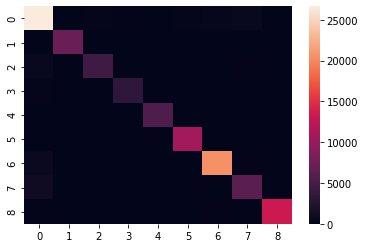

In [16]:
sns.heatmap(confusion_matrix(y_test,y_pred_tuned))

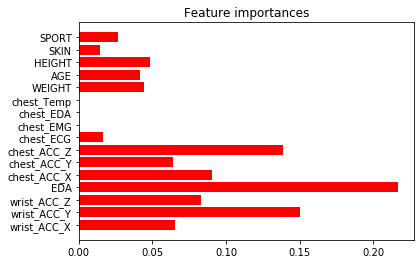

In [17]:
# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.barh(x_train.columns, tuned_random_forest_clf.feature_importances_,
       color="r", align="center")
plt.show()

### Create a boolean to determine if there is a movement or not

In [23]:
reduced_df.index = range(len(reduced_df))

from math import sqrt
 
def Sqr(a):
    return a*a
 
def Distance(x1,y1,x2,y2,z1,z2):
    return sqrt(Sqr(y2-y1)+Sqr(x2-x1)+Sqr(z2-z1)) 

def get_movement(body_part):
    
    movement = []

    movement.append(0)
    
    for i in range(1,len(reduced_df[f'{body_part}_ACC_Z'])):
        z1 = reduced_df[f'{body_part}_ACC_Z'][i-1]
        z2 = reduced_df[f'{body_part}_ACC_Z'][i]
        y1 = reduced_df[f'{body_part}_ACC_Y'][i-1]
        y2 = reduced_df[f'{body_part}_ACC_Y'][i]
        x1 = reduced_df[f'{body_part}_ACC_X'][i-1]
        x2 = reduced_df[f'{body_part}_ACC_X'][i]
        distance = Distance(x1,y1,x2,y2,z1,z2)

        if distance>=0.01:
            movement.append(1)
        else:
            movement.append(0)
            
    return movement
        
reduced_df['chest_movement'] = get_movement('chest')
reduced_df['wrist_movement'] = get_movement('wrist')

C:\Users\a2c18\Anaconda3\lib\site-packages\ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\a2c18\Anaconda3\lib\site-packages\ipykernel_launcher.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


### Random forest tuned + movements features

In [24]:
train, test = train_test_split(reduced_df, test_size=0.2)

x_train = train.drop(columns=['activity'])
y_train = train['activity']

x_test = test.drop(columns=['activity'])
y_test = test['activity']

tuned_random_forest_clf = RandomForestClassifier(n_estimators=200,min_samples_split=5, min_samples_leaf=2, max_features='sqrt',max_depth=45, bootstrap=False)
tuned_random_forest_clf.fit(x_train, y_train)

y_pred_tuned = tuned_random_forest_clf.predict(x_test)

In [30]:
print(metrics.classification_report(y_test,y_pred_tuned))

              precision    recall  f1-score   support

         0.0       0.89      0.94      0.91     26550
         1.0       0.99      0.99      0.99      6658
         2.0       0.92      0.83      0.87      4860
         3.0       0.96      0.90      0.93      3424
         4.0       0.97      0.99      0.98      5308
         5.0       0.97      0.99      0.98     10219
         6.0       0.97      0.95      0.96     20497
         7.0       0.88      0.84      0.86      7039
         8.0       0.99      0.97      0.98     12685

    accuracy                           0.94     97240
   macro avg       0.95      0.93      0.94     97240
weighted avg       0.94      0.94      0.94     97240



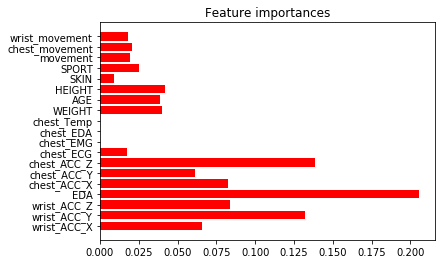

In [26]:
# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.barh(x_train.columns, tuned_random_forest_clf.feature_importances_,
       color="r", align="center")
plt.show()

### Comparaison des modèles avec le modèle optimisé

[0.9384953525723831, 0.7922425047986708, 0.9216727819060319, 0.9424400141137959]


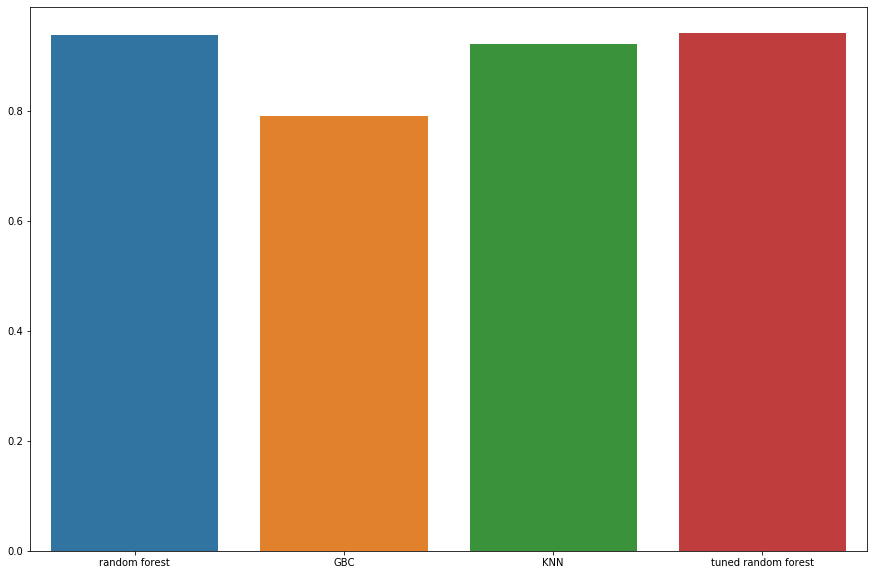

In [41]:
f, ax = plt.subplots(figsize=(15, 10))
list_score = [metrics.f1_score(y_test,y_pred_RF,average='macro'),metrics.f1_score(y_test,y_pred_gbc,average='macro'),metrics.f1_score(y_test,y_pred_KNC,average='macro'),metrics.f1_score(y_test,y_pred_tuned,average='macro')]
sns.barplot(['random forest', 'GBC', 'KNN','tuned random forest'], list_score)
print(list_score)

### Saving the model

In [18]:
filename = 'tuned_RFC.sav'
pickle.dump(tuned_random_forest_clf, open(filename, 'wb'))

In [11]:
filename = 'RFC.sav'
pickle.dump(RF_clf, open(filename, 'wb'))